In [1]:
from dqf import dqf_from_nav_background

In [2]:
from datetime import datetime

In [3]:
# All this will get replaced with output from Bitzer's code. 
# Note shapes of arrays should match below.
import joblib
lat, lon, back_in = joblib.load('/Users/ebruning/Downloads/nav_bkgnd.joblib')
# Handle subsetting
back = back_in[:1299, :1370]
lat.shape = (1299, 1370)
lon.shape = (1299, 1370)

dn_max = 13000
thresh_fJ = 8 - 8*back.astype(float)/float(dn_max)

start = datetime(2024,3,13,0,0,0)
end = datetime(2024,3,13,0,2,30)

In [4]:
# TODO in dqf.py:
# Update dqf_from_nav_background to use the correct min and mix for back_cal,
#    which is as easy as changing the kwargs passed to scale_shift_back

outfile = dqf_from_nav_background(start, end, lat, lon, back, back, thresh_fJ, cache_key='test01')

(5425,) (5425,)
(5424,) (5424,)
(5424, 5424) (5424, 5424)
-0.151844 0.151844


# Plot what we just created

In [5]:
import xarray as xr
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [6]:
from dqf import fde_colors, flag_colors, back_colors, dqp_mask, dqp_labels

dqp_colors = fde_colors + flag_colors
back_cmap = colors.ListedColormap(back_colors)
dqp_cmap = colors.ListedColormap(dqp_colors)

In [7]:
ds = xr.open_dataset(outfile)

In [8]:
ds

<xarray.Dataset>
Dimensions:                         (x: 5424, y: 5424)
Coordinates:
  * x                               (x) float32 -0.1518 -0.1518 ... 0.1518
  * y                               (y) float32 0.1518 0.1518 ... -0.1518
Data variables:
    goes_imager_projection          int32 ...
    DQF                             (y, x) float32 ...
    nominal_satellite_subpoint_lat  float64 ...
    nominal_satellite_subpoint_lon  float64 ...
Attributes: (12/29)
    cdm_data_type:             Image
    Conventions:               CF-1.7
    id:                        93cb84a3-31ef-4823-89f5-c09d88fc89e8
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    instrument_type:           GOES R Series Geostationary Lightning Mapper
    iso_series_metadata_id:    f5816f53-fd6d-11e3-a3ac-0800200c9a66
    ...                        ...
    production_site:           TTU
    scene_id:                  Full Disk
    spatial_resolution:        2km at nadir
    time_coverage_end:         2024-03-13T00:02:30Z
    time_coverage_start:       2024-03-13T00:00:00Z
    timeline_id:               ABI Mode 3

In [9]:
dqf_raw = ds.DQF.astype('u1').values
dqp_image_only = np.bitwise_and(dqp_mask, dqf_raw)
back_image_only = np.right_shift(dqf_raw, 4)

In [10]:
# fig, ax = plt.subplots(1,1)

# ds.DQF.astype('u1').plot.imshow(ax=ax)

# plt.figure(figsize=(6,6))
# # plt.imshow(interp_field, cmap='gray')
# plt.pcolormesh(ds.x,ds.y,interp_field_from_cached, cmap='gray')
# plt.xlabel('Fixed grid x (rad)')
# plt.ylabel('Fixed grid y (rad)')

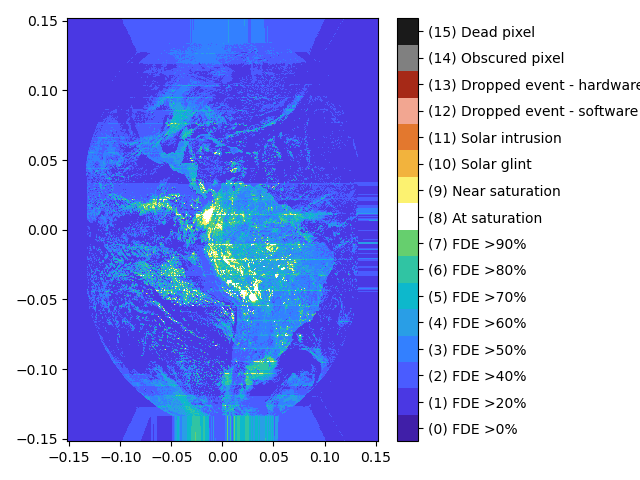

In [11]:
plt.figure()
plt.pcolormesh(ds.x, ds.y, dqp_image_only, cmap=dqp_cmap, vmin=-0.5, vmax=15.5)
cbar = plt.colorbar(ticks=np.arange(16))
cbar.ax.set_yticklabels(dqp_labels)
plt.tight_layout()

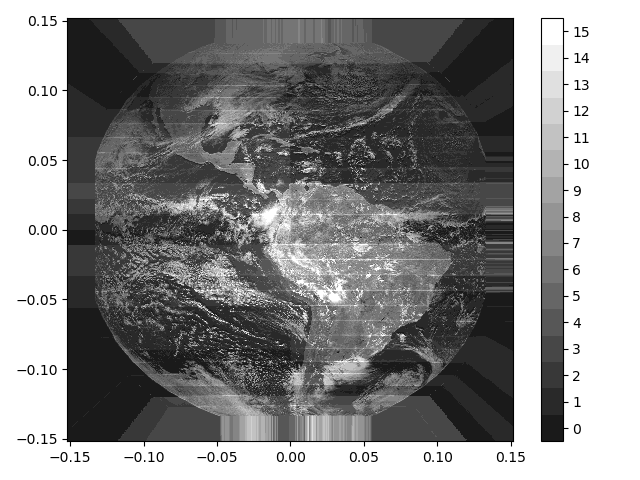

In [12]:
plt.figure()
plt.pcolormesh(ds.x, ds.y, back_image_only, cmap=back_cmap, vmin=-0.5, vmax=15.5)
cbar = plt.colorbar(ticks=np.arange(16))
plt.tight_layout()

# Create colormap files for AWIPS

In [13]:
def rgb_color_list_to_xlm_color(colorlist):
    return '\n'.join('    <color a="1.0" b="{2:4.3f}" g="{1:4.3f}" r="{0:4.3f}"/>'.format(*c) for c in colorlist)

dqp_colors_xml = rgb_color_list_to_xlm_color(dqp_colors)
back_colors_xml = rgb_color_list_to_xlm_color(back_colors)

In [14]:
colormap_template = """<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<colorMap>
{0}
</colorMap>
"""

In [15]:
dqp_xml = colormap_template.format(dqp_colors_xml)
back_xml = colormap_template.format(back_colors_xml)

In [16]:
with open("glm_dqp.cmap", "w") as f:
    f.write(dqp_xml)

with open("glm_background.cmap", "w") as f:
    f.write(back_xml)